In [61]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import time
plt.rcParams['figure.figsize'] = [16, 9]

In [79]:
class ARIMA(object):
    def __init__(self, d_i, s_i, p, s, error = 28):
        # amount of times differentiated for trend
        self.d_i = d_i
        # amount of times differentiated for seasonality
        self.s_i = s_i
        #seasonality
        self.s = s
        self.window = p
        self.error = error 
        
    def diff_basic(self, target, interval, diff_n):
        self.differ = target[interval:] - target[:-interval]
        for d in range(diff_n - 1):
            differ_init = self.differ
            self.differ = differ_init[interval:] - differ_init[:-interval]
        return self.differ
    
    def diff_all(self, data):
        trend_m = self.diff_basic(data, 1, self.d_i)
        season_m = self.diff_basic(trend_m, self.s, self.s_i)
        return season_m
    
    def integrate_basic(self, target, interval, diff_n):
        self.integ = target[interval:] + target[:-interval]
        for d in range(diff_n - 1):
            integ_init = self.integ
            self.integ = integ_init[interval:] + integ_init[:-interval]
        return self.integ
            
    def integrate_all(self, data):
        trend_p = self.integrate_basic(data, 1, self.d_i)
        season_p = self.integrate_basic(trend_p, self.s, self.s_i)
        return season_p

    def fit(self, data, target):
        target = self.diff_all(target)
        self.data = np.reshape(np.array(data[:self.window]), (1, self.window))
        self.target = np.reshape(np.array(target[:self.window]), (1, self.window))
        
        data_f = self.data
        target_f = self.target
                
        self.w = np.linalg.pinv(data_f.T.dot(data_f)).dot(data_f.T).dot(target_f)
        self.mean = np.mean(self.target)
    
    def predict(self, n_step):
        data_fin = self.data
        y_fin = []
        for i in range(n_step): 
            y_new = self.mean + data_fin.dot(self.w) + self.error
            y_fin.append(y_new)
        res = np.ravel(y_fin)
        result = self.integrate_all(res)
        return np.ravel(result)

In [80]:
model = ARIMA(d_i = 1, s_i = 2, p = 65, s = 7)

In [81]:
data_wage = pd.read_csv("./data/monthly-wage.csv", sep=";")
data_wage.Month = data_wage.Month.apply(lambda x: datetime.timestamp(datetime.strptime(x, "%Y-%m")))
data = data_wage.Month
target = data_wage["Real wage"].values

In [82]:
model.fit(data, target)
res = model.predict(1)
fin = np.append(target, res)

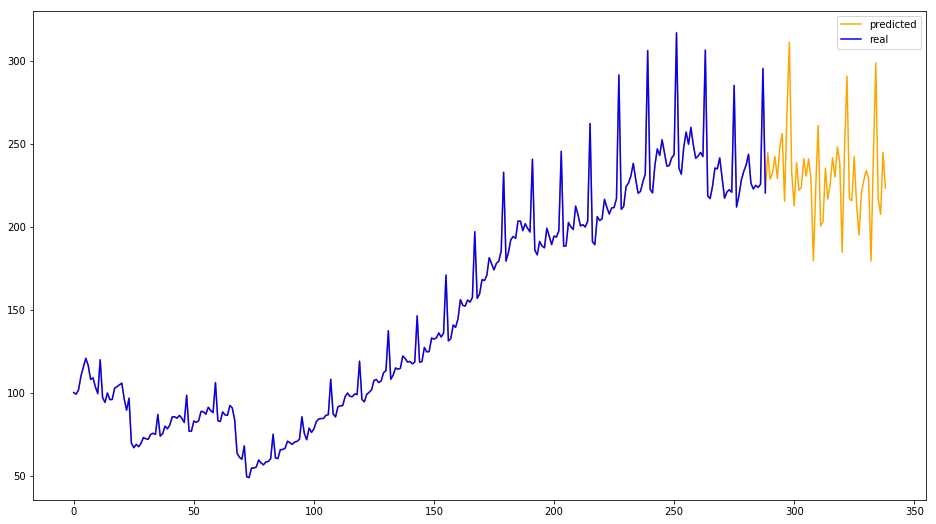

In [83]:
plt.plot(fin, label = "predicted", color = "orange")
plt.plot(target, label = "real", color = "blue")
plt.legend()